In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0)]


# Process Data

In [5]:
# Confirmed, Recovered and Death Cases
IRD = transform.IRD(min_confirmed=100, min_recovered=0, min_deaths=0)

In [6]:
min_days = 14
max_days = 28
cases = {}
deaths = {}
start_days = np.argmax((IRD[0].values>=50),axis=1)
for i, country in enumerate(IRD[0].index):
    if len(IRD[0].T[country].values[start_days[i]:])>=min_days:
        time_slice = slice(start_days[i], start_days[i]+max_days, 1)
        
        cases[country] = np.array(IRD[0].T[country].values[time_slice]).astype(np.float32)
        deaths[country] = np.array(IRD[2].T[country].values[time_slice]).astype(np.float32)

In [7]:
pops = transform.population()

Number of unmatched regions : 46
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


In [8]:
len(cases), len(IRD[0])

(109, 125)

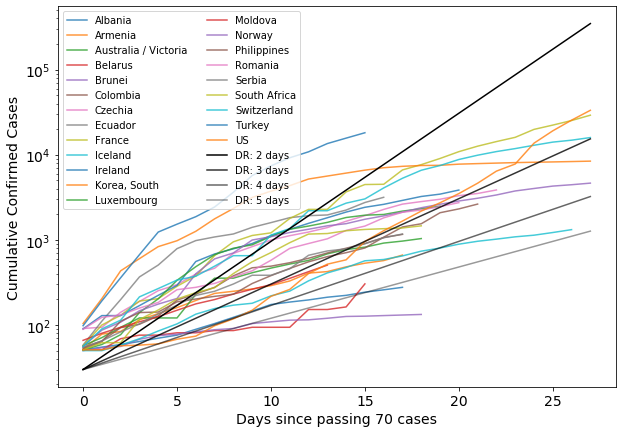

In [9]:
plt.figure(figsize=(10, 7))
t = np.arange(np.max([len(cases[c]) for c in cases.keys()]))
for i, c in enumerate(cases.keys()):
    if i%4==0:
        plt.semilogy(cases[c], alpha = 0.8, label=c)

for i in range(2, 6):
    plt.semilogy(t, 30*(2.0**(1.0/float(i)))**t, 'k', alpha=1.0-(i-2)*0.2, label=f'DR: {i} days')
        
plt.ylabel('Cumulative Confirmed Cases')
plt.xlabel('Days since passing 70 cases')
plt.legend(ncol=2, fontsize=10)

In [9]:
avg_days = np.sum([len(cases[c]) for c in cases.keys()])/len(cases)
print(f'Average number of days per region : {str(np.round(avg_days, 1))} days')

Average number of days per region : 23.0 days


In [10]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [11]:
def model():
    
    N = len(cases)
    
    ############
    # Initial Infection Rate
    Ii = normalHP('Ii', 50.0, 20.0, N)
    # Infection Growth Rate
    GR = normalHP('GR', 1.33, 0.5, N)
    # Time to Death
    alpha = normalHP('alpha', 10.0, 5.0, N)
#     R0 = normalHP('R0', 2.5, 0.5, N)
    # Create likelihood for each country
    for i, country in enumerate(list(cases.keys())):
        t = np.arange(len(cases[country]))
        confirmed = cases[country]
        dead = deaths[country]
        
        # Likelihood
        numpyro.sample(country+'_I', 
                       dist.Poisson((Ii[i]*GR[i]**t)), # Exponential regression
                       obs=confirmed)
        
        numpyro.sample(country+'_D', 
                       dist.Poisson(alpha[i]*GR[i]**t), # Exponential regression
                       obs=dead)
#         (GR[i]**t-1.0)/(R0[i]-1)

In [12]:
N = len(cases)
init_params = {'Ii_grp_mean': 50.0*np.ones((N_chains, 1)),
               'Ii_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'Ii_ind': 50.0*np.ones((N_chains, N)),
               'GR_grp_mean': 1.33*np.ones((N_chains, 1)),
               'GR_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'GR_ind': 1.33*np.ones((N_chains, N)),
               'alpha_grp_mean': 2.5*np.ones((N_chains, 1)),
               'alpha_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'alpha_ind': 2.5*np.ones((N_chains, N))
#                'R0_grp_mean': 2.5*np.ones((N_chains, 1)),
#                'R0_grp_sigma': 0.1*np.ones((N_chains, 1)),
#                'R0_ind': 2.5*np.ones((N_chains, N))
               }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=N_chains)
rng_key = random.PRNGKey(1)

In [13]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

sample: 100%|██████████| 1500/1500 [28:24<00:00,  1.14s/it, 81 steps of size 1.77e-03. acc. prob=0.87]   


Time taken to compile model and draw samples : 1801.1128339767456 s


In [14]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/3.1_EXPsamples.h5', 'w') as fp:
    for key in samples:
        fp[key] = samples[key]
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
    GR_grp_mean[0]      1.15      0.00      1.15      1.15      1.16     13.13      1.06
   GR_grp_sigma[0]      0.06      0.00      0.06      0.05      0.06      2.80      2.14
         GR_ind[0]      1.18      0.00      1.18      1.17      1.18     17.01      1.00
         GR_ind[1]      1.11      0.00      1.11      1.10      1.11     29.10      1.00
         GR_ind[2]      1.18      0.00      1.18      1.18      1.18     75.96      1.05
         GR_ind[3]      1.16      0.00      1.16      1.15      1.16     20.79      1.01
         GR_ind[4]      1.19      0.00      1.19      1.19      1.19     88.02      1.01
         GR_ind[5]      1.16      0.00      1.16      1.15      1.16     57.03      1.00
         GR_ind[6]      1.18      0.00      1.18      1.18      1.18     86.26      1.00
         GR_ind[7]      1.16      0.00      1.16      1.16      1.16     48.26      1.02
         GR_ind[8]  

Number of divergences: 999


In [15]:
samples = {}
with h5py.File('../data/nb_samples/3.1_EXPsamples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)].value

/usr/local/lib/python3.6/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Growth rate for all regions together

Text(0.5, 0, 'Growth Rate [day$^{-1}$]')

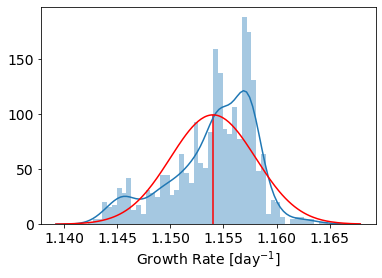

In [16]:
smp = samples['GR_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'Growth Rate [day$^{-1}$]')

# Growth rates for each region

Text(0.5, 0, 'Growth Rate [day$^{-1}$]')

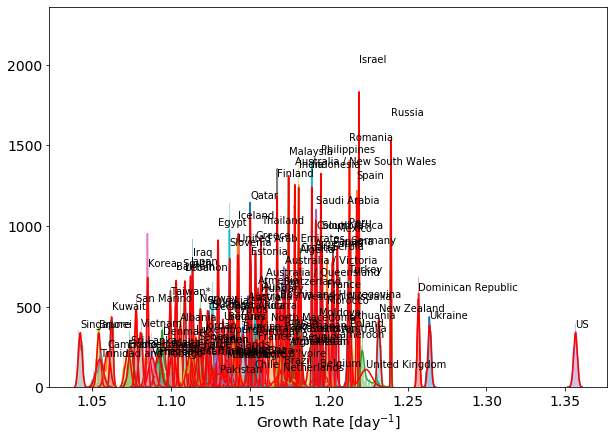

In [17]:
plt.figure(figsize=(10,7))
l_b, u_b = 1.0, 1.4

for i in range(N):
    smp = mcmc.get_samples()['GR_ind'][:,i]
    mn, std = norm.fit(smp)
    sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'Growth Rate [day$^{-1}$]')
# plt.xlim(l_b, u_b)

# Initial Deaths for all regions together

Text(0.5, 0, 'Initial deaths')

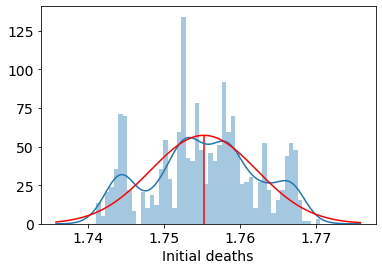

In [23]:
smp = samples['alpha_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'Initial deaths')

# Initial Deaths for each region

Text(0.5, 0, 'Initial Deaths')

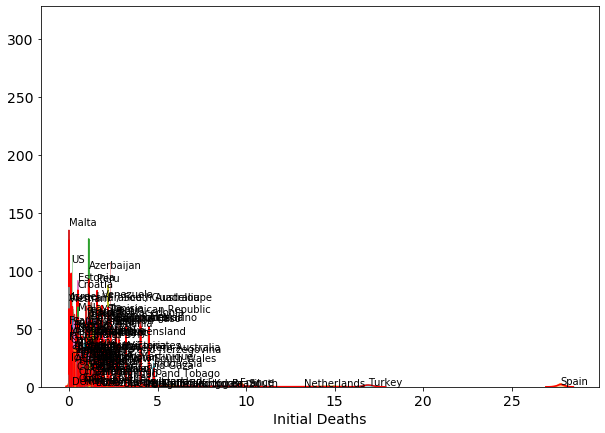

In [27]:
plt.figure(figsize=(10,7))
l_b, u_b = 0.0, 5.0

for i in range(N):
    smp = mcmc.get_samples()['alpha_ind'][:,i]
    mn, std = norm.fit(smp)
    sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'Initial Deaths')
# plt.xlim(l_b, u_b)

# Initial Infected for all regions together

Text(0.5, 0, 'Initial Infected')

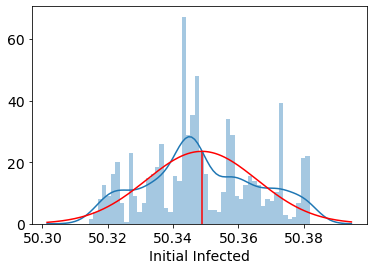

In [26]:
smp = samples['Ii_grp_mean']
mn, std = norm.fit(smp)
sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
plt.vlines(mn, 0, norm.pdf(mn, mn, std), 'r')

plt.xlabel(r'Initial Infected')

# Initial Infected for each region

Text(0.5, 0, 'Initial Infected')

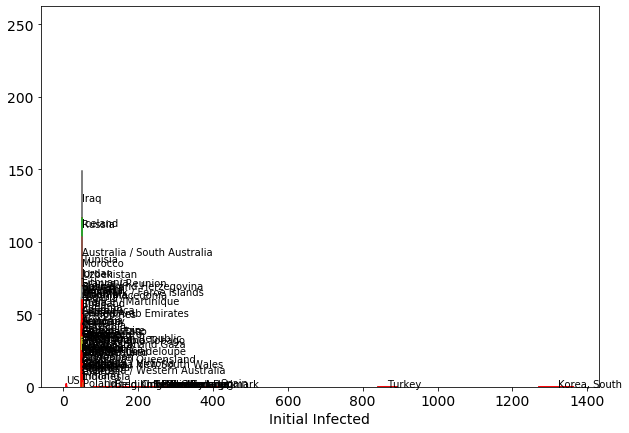

In [28]:
plt.figure(figsize=(10,7))
l_b, u_b = 0.0, 5.0

for i in range(N):
    smp = mcmc.get_samples()['Ii_ind'][:,i]
    mn, std = norm.fit(smp)
    sns.distplot(smp, bins=50, fit=norm, fit_kws={'color':'red'})
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), list(cases.keys())[i], fontsize=10)

plt.xlabel(r'Initial Infected')
# plt.xlim(l_b, u_b)

In [ ]:
t = np.arange(15)
i = np.argmax(np.array([x=='South Africa' for x in list(deaths.keys())]))
plt.plot(np.mean(samples['Ii_ind'][:,i])*np.mean(samples['GR_ind'][:,i])**t)
plt.plot(cases['South Africa'])

In [ ]:
t = np.arange(15)
i = np.argmax(np.array([x=='South Africa' for x in list(deaths.keys())]))
plt.plot(np.mean(samples['GR_ind'][:,i])**(t-np.mean(samples['Td_ind'][:,i])))
plt.plot(deaths['South Africa'])

In [ ]:
plt.hist(samples['Td_ind'][:,i], bins=30);

In [ ]:
plt.plot(deaths['South Africa'])